# Implementing Custom RandomSearchCV

In [ ]:
import numpy as np
import random

In [ ]:
# This function is to return single K value within the range given for hyperparamter
# As we are sampling K values for KNN, return only odd numbers

def sample_odd_nums(param_range):
  # sampling using random.sample
  sampled_num = random.sample(range(param_range[0],param_range[1]),1)
  # checking to skip odd number and the number 1
  if ((sampled_num[0] % 2) != 0) & (sampled_num[0] != 1):
    return(sampled_num[0])
  else:
    # calling the same function recursively if the sampled values is not odd or if it is 1
    return(sample_odd_nums(param_range))

In [ ]:
# This function returns requested number of K values by using the above function for sampling

def sample_K_values(param_range,num_of_K):
  i = 0
  list_of_K = []
  # while loop is to ensure requested number of values for K are sampled from the above function
  # since we are using "set" to avoid duplicates, the loop may have to run more than 10 times and hence used while loop
  while i < num_of_K:
    list_of_K.append(sample_odd_nums(param_range))
    list_of_K = list(set(list_of_K))
    i += 1
    if len(list_of_K) < i:
      i -= 1
  list_of_K.sort()
  return(list_of_K)

In [ ]:
# This function is to remove duplicate samples from list of indices by comparing with another list
# and to sample requested number of points from the updated list.
# This is requred to create fixed number of samples for 3 folds

def subtract_sample(lst_1,lst_2,sample_len):
  temp_list = list(set(lst_1)-set(lst_2))
  temp_list = random.sample(temp_list,sample_len)
  return(temp_list)

In [ ]:
#This function is to sample the indices for the x_train set and divide the dataset for each folds

def sample_indices(x_train,folds):
  split_by = 1/folds
  # sample_len is the length of the list sampled indices for each of the folds
  sample_len = int(split_by*len(x_train))
  return_sample = []
  temp_sample = []
  # adding the first set of sampled indices to the list
  return_sample.append(random.sample(range(0, len(x_train)), sample_len))
  # Run the loop for each of the folds.
  # Since we already sampled indices for the first fold, we can start the for loop from 1 instead of 0
  for j in range(1,folds):
    # The length of the list of sampled indices is to pass to the "subtract_sample" function
    return_sample_len = len(np.array(return_sample).flatten('c'))
    # temp_sample is to sample the complete list of indices each time to subtracted with the list that is
    # appending with set of sampled indices for each folds
    temp_sample = random.sample(range(0, len(x_train)), len(x_train))
    # The "subtract_sample" function returns unique sample indices to the final list in each iteration
    # The np.array().flatten('c') is used to convert the nested lists to a single list.
    return_sample.append(subtract_sample(temp_sample,np.array(return_sample).flatten('c'),sample_len))
  # "complete_sample" has the sampling data for all the indices, while "return_sample" is a list of
  # lists for all the folds (for 5 folds, there will be 5 lists inside a single list - using as testing data)
  complete_sample = random.sample(range(0, len(x_train)), len(x_train))
  return(return_sample,complete_sample)

In [ ]:
# This function implements RandomSearchCV algorithm

def RandomSearchCV(x_train,y_train,classifier,param_range,folds):
  trainscores = []
  testscores  = []
  # Sample 10 values for the hyperparameter - K using the "sample_K_values" function
  params = sample_K_values(param_range,10)
  # Sample the indices for all the values in the dataset x_train and split the
  # indices dataset based on the number of folds
  sampled_indices = sample_indices(x_train,folds)
  # Iterate through all the hyperparamter values
  for k_values in params:
    trainscores_folds = []
    testscores_folds  = []
    train_indices = []
    test_indices = []
    # "sample_indices" return a lists of lists that can be used as test samples for all the folds iteratively
    # and return a complete list of sampled indices. We can subtract test indices from the list of complete indices
    # each time to get the train indices
    test_set,all_indices = sample_indices(x_train,folds)
    # Iterate through all the folds
    for i in range(0,folds):
      # test_set now has set of indices for all the folds, accessing it iteratively for all the folds
      test_indices = test_set[i]
      # get train indices by subtracting test indices from the complete list of indices
      train_indices = list(set(all_indices)-set(test_indices))
      # Get the train and test dataset by passing the indices to the original dataset
      X_train = x_train[train_indices]
      Y_train = y_train[train_indices]
      X_test  = x_train[test_indices]
      Y_test  = y_train[test_indices]
      # Assign the K value to the hyperparameter of the model
      classifier.n_neighbors = k_values
      # Fit the dataset and the class label with the model
      classifier.fit(X_train,Y_train)
      # Get the output and scores
      Y_predicted = classifier.predict(X_test)
      testscores_folds.append(accuracy_score(Y_test, Y_predicted))
      Y_predicted = classifier.predict(X_train)
      trainscores_folds.append(accuracy_score(Y_train, Y_predicted))
    # Find the mean accuracy for all the folds and append it to a list for each of the K values
    trainscores.append(np.mean(np.array(trainscores_folds)))
    testscores.append(np.mean(np.array(testscores_folds)))
  # Return accuracy scores for both train and test evaluations and the list of parameters used
  return trainscores,testscores,params

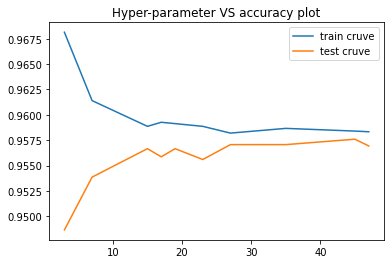

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=60)
neigh = KNeighborsClassifier()
param_range = (1,50)
folds = 3

trainscores,testscores,params = RandomSearchCV(x_train,y_train,neigh,param_range,folds)

plt.plot(params,trainscores, label='train cruve')
plt.plot(params,testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [ ]:
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

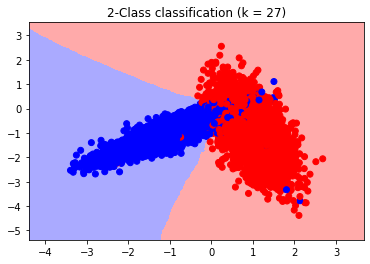

In [ ]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 27)
neigh.fit(x_train, y_train)
plot_decision_boundary(x_train[:, 0], x_train[:, 1], y_train, neigh)